Running Notebook No.2 to build a LSTM NMT.

1. Mounting Google Drive...
Mounted at /content/gdrive

2. Loading tokenizers and padded data...
Done.

3. Splitting data into training (70%), validation (10%), and test (20%) sets...
Done.

4. Initializing encoder and decoder models...
Done.

5. Model training...
Epoch 1, Training Loss 5.1290, Validation Loss 4.4234, Time: 1.97 min
Epoch 2, Training Loss 4.0194, Validation Loss 3.7807, Time: 1.93 min
Epoch 3, Training Loss 3.4570, Validation Loss 3.3906, Time: 1.93 min
Epoch 4, Training Loss 3.0500, Validation Loss 3.1242, Time: 1.93 min
Epoch 5, Training Loss 2.7253, Validation Loss 2.9158, Time: 1.93 min
Epoch 6, Training Loss 2.4568, Validation Loss 2.7613, Time: 1.94 min
Epoch 7, Training Loss 2.2308, Validation Loss 2.6557, Time: 1.96 min
Epoch 8, Training Loss 2.0386, Validation Loss 2.5723, Time: 1.96 min
Epoch 9, Training Loss 1.8739, Validation Loss 2.5171, Time: 1.97 min
Epoch 10, Training Loss 1.7328, Validation Loss 2.4741, Time:

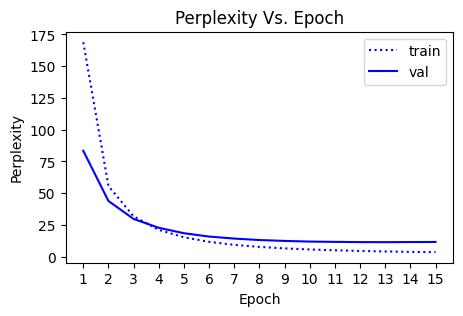

Evaluating model performance on test data...

Test Loss: 2.4214
Perplexity: 11.2620

6. Creating a translator instance with the trained encoder and decoder...
Done.

7. Let's use the translator on a few examples...
Example 1
To be translated: 戸 に は 新しく ペンキ が 塗っ て あっ た 。
Reference translation: there was a new coat of paint on the door
Translator output: they had a car painted
BLEU Score: 1.98
--------------------------------------------------------------------------------
Example 2
To be translated: 早く 起き なさい よ 、 じゃ ない と 遅刻 し ちゃう から ね 。
Reference translation: get up early or you'll be late
Translator output: be sure to go and see us sometime
BLEU Score: 2.78
--------------------------------------------------------------------------------
Example 3
To be translated: 僕 は 都会 の 生活 向き に 出来 て い ない と 思う 。
Reference translation: i don't think that i'm cut out for city life
Translator output: i think i can't live in the country
BLEU Score: 2.57
---------------------------------------------------

In [1]:
"""
* This is the second notebook for my sequence-to-sequence Neural Machine Translation (NMT) project.
* The primary goal of this particular notebook is to build a encoder-decoder model using Long Short-Term Memory (LSTM).
* To better understand LSTM, checkout https://colah.github.io/posts/2015-08-Understanding-LSTMs/.
* To run this notebook, modify the save_dir path below and download the data and tokenizers saved from the first notebook (1.Data Prep).
* The next notebook in this series will be "3.LSTM with Attention".
"""

import os
import numpy as np
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

# ================== config ==================
batch_size = 64
embedding_dim = 128   # controls the dimension of the embedded vectors
hidden_size = 128     # controls the depth of the LSTM layers
epochs = 15
save_dir = '/content/gdrive/My Drive/NMT_Data'  # directory for saved data
model_save_dir = os.path.join(save_dir, 'NMT_Models/simple_LSTM')  # directory for saving the trained models
# ============================================

# Mount Google Drive
def mount_drive():
  from google.colab import drive
  drive.mount('/content/gdrive')

# Load the data and tokenizers that were generated in the Data Prep notebook
def load_data_and_tokenizers(save_dir):
  padded_en = np.load(os.path.join(save_dir, 'padded_english.npy'))
  padded_ja = np.load(os.path.join(save_dir, 'padded_japanese.npy'))
  with open(os.path.join(save_dir, 'english_tokenizer.pkl'), 'rb') as f:
    en_tok = pickle.load(f)
  with open(os.path.join(save_dir, 'japanese_tokenizer.pkl'), 'rb') as f:
    ja_tok = pickle.load(f)
  vocab_size_en = len(en_tok.word_index)
  vocab_size_ja = len(ja_tok.word_index)
  return padded_en, padded_ja, en_tok, ja_tok, vocab_size_en, vocab_size_ja

# Split into train/val/test and create datasets
def prepare_datasets(padded_en, padded_ja):
  train_ja, temp_ja, train_en, temp_en = train_test_split(padded_ja, padded_en, test_size=0.30, random_state=42)
  val_ja, test_ja, val_en, test_en = train_test_split(temp_ja, temp_en, test_size=2/3, random_state=42)
  def make_dataset(x, y):
    return tf.data.Dataset.from_tensor_slices((x, y)).shuffle(len(x)).batch(batch_size)
  return (
    make_dataset(train_ja, train_en),
    make_dataset(val_ja, val_en),
    make_dataset(test_ja, test_en),
    train_ja, train_en, val_ja, val_en, test_ja, test_en
  )

# Define the encoder (using Tensorflow Sub Class API)
class encoder_no_attention(Model):
  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super(encoder_no_attention, self).__init__()
    self.embedding = Embedding(vocab_size + 1, embedding_dim, mask_zero=True)
    self.lstm = LSTM(hidden_size, return_sequences=True, return_state=True)
  def call(self, input):
    x = self.embedding(input)
    encoder_out, encoder_h, encoder_c = self.lstm(x)
    return encoder_out, encoder_h, encoder_c

# Define the decoder
class decoder_no_attention(Model):
  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super(decoder_no_attention, self).__init__()
    self.embedding = Embedding(vocab_size + 1, embedding_dim, mask_zero=True)
    self.lstm = LSTM(hidden_size, return_sequences=True, return_state=True)
    self.dense = Dense(vocab_size + 1)
  def call(self, inputs, initial_state=None):
    x = self.embedding(inputs)
    lstm_out, state_h, state_c = self.lstm(x, initial_state=initial_state)
    logits = self.dense(lstm_out)
    return logits, state_h, state_c

# Define loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# Prepare training data and label for the decoder
def prepare_decoder(target_batch):
  decoder_input = target_batch[:, :-1]
  decoder_target = target_batch[:, 1:]
  return decoder_input, decoder_target

# Forward and backward pass (calculate gradients for encoder and decoder together)
@tf.function
def grad(encoder, decoder, Japanese_input, decoder_input_english, ground_truth_english):
  with tf.GradientTape() as tape:
    # send inputs into encoder, then create encoder_mask. use the states to set up the decoder
    encoder_out, hidden_state, cell_state = encoder(Japanese_input)
    decoder_output, _, _ = decoder(decoder_input_english, initial_state=[hidden_state, cell_state])

    # masked loss calculation
    mask = tf.cast(ground_truth_english != 0, dtype=tf.float32)
    loss_per_token = loss_object(ground_truth_english, decoder_output)
    masked_loss = loss_per_token * mask
    loss_value = tf.reduce_sum(masked_loss) / tf.reduce_sum(mask)

    # get gradients over the parameters from both encoder and decoder
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss_value, trainable_vars)

    return loss_value, gradients

# Custom training loop (train encoder and decoder together)
def custom_training(num_epochs, train_dataset, val_dataset, encoder, decoder, optimizer, model_save_dir=None):
  train_loss_results = []
  val_loss_results = []
  best_val_loss = float('inf')
  best_encoder_weights = None
  best_decoder_weights = None
  best_epoch = -1

  for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    val_loss_avg = tf.keras.metrics.Mean()
    start_time = tf.timestamp()

    # training loop
    for japanese_input, english_input in train_dataset:
      decoder_input_english, ground_truth_english = prepare_decoder(english_input)
      loss_value , grads = grad(encoder, decoder, japanese_input, decoder_input_english, ground_truth_english)
      trainable_vars = encoder.trainable_variables + decoder.trainable_variables
      optimizer.apply_gradients(zip(grads, trainable_vars))
      epoch_loss_avg(loss_value)

    # validation loop
    for japanese_input, english_input in val_dataset:
      decoder_input_english, ground_truth_english = prepare_decoder(english_input)
      val_loss_value , _ = grad(encoder, decoder, japanese_input, decoder_input_english, ground_truth_english)
      val_loss_avg(val_loss_value)

    train_loss = epoch_loss_avg.result()
    val_loss = val_loss_avg.result()
    train_loss_results.append(train_loss)
    val_loss_results.append(val_loss)

    # save the temporary best model weights
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_encoder_weights = encoder.get_weights()
      best_decoder_weights = decoder.get_weights()
      best_epoch = epoch + 1

    # epoch summary
    epoch_time = (tf.timestamp() - start_time) / 60
    print(f"Epoch {epoch+1}, Training Loss {train_loss:.4f}, Validation Loss {val_loss:.4f}, Time: {epoch_time:.2f} min")

  # load best models
  encoder.set_weights(best_encoder_weights)
  decoder.set_weights(best_decoder_weights)
  print(f"Training completed. Best model from epoch {best_epoch} with Validation Loss = {best_val_loss:.4f}")

  # save the final best model after training is completed
  if model_save_dir:
    os.makedirs(model_save_dir, exist_ok=True)
    encoder_path = os.path.join(model_save_dir, 'best_encoder.weights.h5')
    decoder_path = os.path.join(model_save_dir, 'best_decoder.weights.h5')
    encoder.save_weights(encoder_path)
    decoder.save_weights(decoder_path)
    print(f"Best model saved to: {model_save_dir}")

  return train_loss_results, val_loss_results

# Plot training progress with perplexity
def plot_perplexity(train_loss, val_loss, epochs):
  train_perplexity = np.exp(train_loss)
  val_perplexity = np.exp(val_loss)
  plt.figure(figsize=(5,3))
  plt.plot(range(1, len(train_perplexity)+1), train_perplexity, label='train', linestyle='dotted', color='blue')
  plt.plot(range(1, len(val_perplexity)+1), val_perplexity, label='val', linestyle='solid', color='blue')
  plt.xticks(range(1, epochs+1))
  plt.xlabel('Epoch')
  plt.ylabel('Perplexity')
  plt.legend()
  plt.title("Perplexity Vs. Epoch")
  plt.show()

# Evluation on test dataset
def evaluate_on_test(test_dataset, encoder, decoder):
  test_loss_avg = tf.keras.metrics.Mean()
  for japanese_input, english_input in test_dataset:
    decoder_input_english, ground_truth_english = prepare_decoder(english_input)
    test_loss_value , _ = grad(encoder, decoder, japanese_input, decoder_input_english, ground_truth_english)
    test_loss_avg(test_loss_value)
  print("\nTest Loss: {:.4f}".format(test_loss_avg.result()))
  print("Perplexity: {:.4f}".format(np.exp(test_loss_avg.result())))

# Build a translator class
class Translator(tf.Module):
  def __init__(self, ja_tok, en_tok, encoder, decoder, start_token='start', end_token='end', max_tokens=100):
    self.ja_tok = ja_tok
    self.en_tok = en_tok
    self.encoder = encoder
    self.decoder = decoder
    self.start_token = start_token
    self.end_token = end_token
    self.start_token_id = en_tok.word_index[start_token]
    self.end_token_id = en_tok.word_index[end_token]
    self.max_tokens = max_tokens

  def __call__(self, sentence):
    # convert input sentence from str to list
    if isinstance(sentence, str):
      sentence = [sentence]

    # prepare the Japanese sentence and pass it through the encoder
    encoder_input = self.ja_tok.texts_to_sequences(sentence)
    encoder_input = tf.keras.preprocessing.sequence.pad_sequences(encoder_input, padding='post')
    encoder_input = tf.convert_to_tensor(encoder_input)
    encoder_out, hidden_state, cell_state = self.encoder(encoder_input)

    # initialize output tensor for Decoder
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, tf.constant([self.start_token_id], dtype=tf.int64))
    h, c = hidden_state, cell_state # use the encoder's final h_state and c_state as the initial states of the decoder

    # generation
    for i in tf.range(self.max_tokens):
      current_output = tf.transpose(output_array.stack())  # a list of tokens
      current_token = current_output[:, -1:]  # get the last token

      # feed last token into decoder to get prediction for the next one
      logits, h, c = self.decoder(current_token, initial_state=[h, c])
      predicted_id = tf.argmax(logits[:, -1:, :], axis=-1)
      output_array = output_array.write(i + 1, predicted_id[0])

      # check for end token
      if predicted_id[0][0].numpy() == self.end_token_id:
        break

    output = tf.transpose(output_array.stack())  # shape: (1, seq_len)
    output_tokens = output.numpy()[0]

    # convert token ids back to words
    index_word = self.en_tok.index_word
    translated_tokens = [index_word.get(id, '') for id in output_tokens if id != 0]
    translated_text = ' '.join(translated_tokens[1:-1])  # skip <start> and <end> for readability
    return translated_text, translated_tokens

# Calculate BLEU score for translated text
def rate_bleu_score(reference_text, translated_text, weights=(0.25, 0.25, 0.25, 0.25)):
  smoother = SmoothingFunction().method1
  reference_tokens = reference_text.split()
  candidate_tokens = translated_text.split()
  bleu_score = sentence_bleu([reference_tokens], candidate_tokens, weights=weights, smoothing_function=smoother)
  return bleu_score

# Main function
def main():
  print("=" * 80)
  print("Running Notebook No.2 to build a LSTM NMT.")
  print("=" * 80)

  # Mount Google Drive
  print("\n1. Mounting Google Drive...")
  mount_drive()

  # Load data from Drive
  print("\n2. Loading tokenizers and padded data...")
  padded_en, padded_ja, en_tok, ja_tok, vocab_size_en, vocab_size_ja = load_data_and_tokenizers(save_dir)
  print("Done.")

  # Split data
  print("\n3. Splitting data into training (70%), validation (10%), and test (20%) sets...")
  train_ds, val_ds, test_ds, train_ja, train_en, val_ja, val_en, test_ja, test_en = prepare_datasets(padded_en, padded_ja)
  print("Done.")

  # Initialize encoder, decoder, and optimizer
  print("\n4. Initializing encoder and decoder models...")
  encoder = encoder_no_attention(vocab_size_ja, embedding_dim, hidden_size)
  decoder = decoder_no_attention(vocab_size_en, embedding_dim, hidden_size)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  sample_ja, sample_en = next(iter(train_ds))
  dec_input, _ = prepare_decoder(sample_en)
  _ = encoder(sample_ja)
  _ = decoder(dec_input)
  print("Done.")

  # Train model
  print("\n5. Model training...")
  train_loss, val_loss = custom_training(epochs, train_ds, val_ds, encoder, decoder, optimizer, model_save_dir=model_save_dir)
  plot_perplexity(train_loss, val_loss, epochs)
  print("Evaluating model performance on test data...")
  evaluate_on_test(test_ds, encoder, decoder)

  # Create translator instance
  print("\n6. Creating a translator instance with the trained encoder and decoder...")
  os.system('apt install -y mecab mecab-ipadic-utf8') # installing MeCab
  os.system('pip install mecab-python3 unidic-lite')
  translator = Translator(ja_tok, en_tok, encoder, decoder, start_token='start', end_token='end', max_tokens=padded_en.shape[1])
  print("Done.")

  # Test translation on some examples
  print("\n7. Let's use the translator on a few examples...")
  indice_chosen = [10, 20, 30, 40, 50]
  for i, indice in enumerate(indice_chosen, 1):
    japanese_test = ja_tok.sequences_to_texts([test_ja[indice]])[0].replace('start', '').replace('end', '').strip()
    reference_translation = en_tok.sequences_to_texts([test_en[indice]])[0].replace('start', '').replace('end', '').strip()
    print('Example', i)
    print('To be translated:', japanese_test)
    print('Reference translation:', reference_translation)

    # call translator
    translated_text, translated_tokens = translator(japanese_test)
    print('Translator output:', translated_text)

    # calculate BLEU score
    bleu_score = rate_bleu_score(reference_translation, translated_text)
    print(f'BLEU Score: {bleu_score * 100:.2f}') # note BLEU is usually reported in range 0-100, but it is not a percentage.
    print('-' * 80)

  print("\n" + "=" * 80)
  print("You've hit the end of Notebook 2. \nIn the next one, we will add Attention Mechanism to this model for a comparison!")
  print("=" * 80)


if __name__ == '__main__':
  main()